# Introduction/Business Problem


<!---Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.--->

> People have different preferences when looking for a place/state/city to live. In this project I investigate which of the seven major rising tech hub cities (Seattle, New York, Colorado, Austin, Los Angeles, Chicago, and Boston) is most similar to San Francisco imagining a persons is deciding which job to accept between all the mentioned cities. This cities were selected based on a recent article ranking the top tech cities in the united states (https://builtin.com/tech-hubs). This project is mostly targeted to STEM professionals looking to move out of San Francisco due to the current housing crisis and rising living expenses but wants to mantain a similar lifestyle/neighborhood.

# Data

> I will be taking the top recommended popular venues in San Francisco along with the venues categories and their rating to try and build a profile for each city. Same thing will be performed for the previously mentioned cities. Once the data is gathered, using the `Foursquare API`, it will be processed to create a purley numerical dataset to pass it as input to a clustering algorithm using Scikit-Learn K-means algorithm. Based on closeness, I expect Los Angeles or Seattle to be the most similar city and San Francisco the least related. Factors that will be taken into account are most common venues, their ratings and their categories. This includes exploring how many parks, bars, coffee places, etc. are in each city. At the end we will look at the results and make some conclusions. 

# Methodology/Table of Contents

- Importing Modules
- Gathering Data
- Processing Data
- Building and Training a Clustering Model
- Results
    - Plot Map to Visualize Results
    - Qualitative Analysis
- Conclusions

# Import Modules

For this project, we use the `geopy` package to collect latitudes and longitudes of specific addresses. The `pandas` package is used to read the `json` responses and process the dataframes. The `Scikit-Learn` package will be used to preprocess the features (normalization, etc) and modeling (clustering algorithms). The `folium` python package is use to create map visualizations.  

In [36]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from IPython.display import Image

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# GEOPY: Gathering Latitudes and Longitudes

Let's get the coordinates for all 8 cities mentioned in the introduciton which will serve as the centerpoints to get nearby recommended values.

In [37]:
# Instantiating the geographic locator
geolocator = Nominatim(user_agent="ny_explorer")

In [38]:
# Specifying the address
address = 'Downtown, San Francisco'

# Gathering the location coordinates
location_sf = geolocator.geocode(address)

# Placing coordinates to variables
latitude_sf = location_sf.latitude
longitude_sf = location_sf.longitude
print('The geograpical coordinate of Downtown, San Francisco are {}, {}.'.format(latitude_sf, longitude_sf))

The geograpical coordinate of Downtown, San Francisco are 37.7875138, -122.407159.


Let us do this for the one more city:

In [39]:
address = 'Los Angeles, USA'
location_la = geolocator.geocode(address)
latitude_la = location_la.latitude
longitude_la = location_la.longitude
print('The geograpical coordinate of Downtown, Los Angeles are {}, {}.'.format(latitude_la, longitude_la))

The geograpical coordinate of Downtown, Los Angeles are 34.0536909, -118.2427666.


Let us write a function that will allow us to collect coordinates for an aribtrary number of cities to automate the process for future projects (Check geopy_utils.py).

In [40]:
def get_coordinates_df(cities):
    '''Allows the user to create a dataframe which contains
    the latitude and longitude of the requested cities.

    cities [list]: a list containing city and state. For example:
    ['San Diego, California', 'Seattle, Washington']
    '''
    # Initiating empty dataframe
    cities_location = pd.DataFrame(columns=["Cities", "Latitude", "Longitude"])
    
    print("Gathering location information...")
    # Looping through the list of cities
    for i in cities:
        # Specifying the address
        address = "Downtown " + i 

        # Gathering the location coordinates
        location = geolocator.geocode(address)

        # Placing coordinates to variables
        latitude = location.latitude
        longitude = location.longitude

        # Creating a dataframe with calculated values
        processing = pd.DataFrame({"Cities":[i],
                                "Latitude":[latitude],
                                "Longitude":[longitude]})
        
        # Appending Values to cities_location dataframe
        cities_location = cities_location.append(processing)

    print("Finished.")
    return cities_location

We now use the function to build a dataframe with the location (latitude and longitude) of all the cities.

In [41]:
cities_list = ["San Francisco, California", "Denver, Colorado", "Seattle, Washington", "Los Angeles, California", "New York City, NY", "Chicago, Illinois", "Austin, Texas", "Boston, Massachusetts"]
cities = get_coordinates_df(cities_list)
cities

Gathering location information...
Finished.


,Cities,Latitude,Longitude
0,"San Francisco, California",37.787514,-122.407159
0,"Denver, Colorado",39.751770,-105.013873
0,"Seattle, Washington",47.604949,-122.333274
0,"Los Angeles, California",34.042849,-118.247673
0,"New York City, NY",40.599756,-73.946390
0,"Chicago, Illinois",41.881644,-87.632095
0,"Austin, Texas",30.268054,-97.744764
0,"Boston, Massachusetts",42.358602,-71.063875


# Foursquare API

We will now use the foursquare API to get the top 40 venues around each city with a radius of 1000 meters using the GET request.

In [42]:
import config

In [43]:
# Defining credentials and version
CLIENT_ID = config.CLIENT_ID # your Foursquare ID
CLIENT_SECRET = config.CLIENT_SECRET # your Foursquare Secret
VERSION = '20180604'

When calling through the `Foursquare API` results in a JSON response, which we need to process to convert it into a dataframe. The JSON response contains information of many types, but the main `response` is the one of interest. Let's take a look at one of the items in the response. For each item we get information like `location`, the `venue id`, `venue name`, `city`, etc. The `json_normalize` is a pandas module to convert JSON responses to a dataframe. Let us pass the response to `json_normalize` and see what it looks like.

In [44]:
LIMIT = 40 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

In [35]:
# We are using the "Get Venue Recommendations" endpoint
url = "https://api.foursquare.com/v2/search/recommendations"

params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v='20191129',
    ll=(str(latitude_sf) + "," + str(longitude_sf)),
    limit=LIMIT)

# This makes the request based on the location provided
print("Requesting information to Foursquare...")
resp = requests.get(url=url, params=params)
print("Information recieved succesfully.")
# This loads the json response into `data`
print("Loading JSON response...")
data = json.loads(resp.text)
print("Finishing loading response.")

Requesting information to Foursquare...
Information recieved succesfully.
Loading JSON response...
Finishing loading response.


In [36]:
# Extract items from the foursequare response
recommended_venues = data['response']['group']['results']

# Creates a dataframe using the json_normalize module.
print("Converting JSON response to a DataFrame...")
recommended_venues = json_normalize(recommended_venues) # flatten JSON

# filter only the columns we need
print("Filtering DataFrame...")
filtered_columns = ['venue.name', 'venue.id', 'venue.location.formattedAddress', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
recommended_venues = recommended_venues.loc[:, filtered_columns]

print("Finish creating and filtering dataframe.")
recommended_venues.head()

Converting JSON response to a DataFrame...
Filtering DataFrame...
Finish creating and filtering dataframe.


,venue.name,venue.id,venue.location.formattedAddress,venue.categories,venue.location.lat,venue.location.lng
0,Maison Margiela,551cfcaf498e23f2c0115449,"[134 Maiden Ln, San Francisco, CA 94108, Unite...","[{'id': '4bf58dd8d48988d104951735', 'name': 'B...",37.788261,-122.405765
1,Saint Laurent,528d4fe211d2543b7663f4fd,"[108 Geary St, San Francisco, CA 94108, United...","[{'id': '4bf58dd8d48988d104951735', 'name': 'B...",37.787774,-122.405412
2,Williams-Sonoma,4aa45625f964a5207b4620e3,"[340 Post St (btwn Powell & Stockton), San Fra...","[{'id': '58daa1558bbb0b01f18ec1b4', 'name': 'K...",37.788377,-122.407446
3,Tiffany & Co.,4a791992f964a520efe61fe3,"[350 Post St (btwn Powell & Stockton), San Fra...","[{'id': '4bf58dd8d48988d111951735', 'name': 'J...",37.788598,-122.407708
4,James Colgan Union Square,516ddbdee4b03303eba849c8,"[166 Geary St Ste 1600 (Stockton St), San Fran...","[{'id': '4bf58dd8d48988d110951735', 'name': 'S...",37.787656,-122.406326


After gathering the recommended venues we need to use a separate endopoint to get the ratings of each venue. This is a premium called and since we are only allow to make 500 calls per day, we only collect 40 venues for each city. Let us get a rating for the first venue as an example. 

In [38]:
venue_id = "551cfcaf498e23f2c0115449"

url = "https://api.foursquare.com/v2/venues/{}".format(venue_id)

params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v='20191129')

print("Getting rating for Venue ID {}.".format(venue_id))
resp2 = requests.get(url=url, params=params)
data2 = json.loads(resp2.text)
print("Finish loading JSON response.")

Getting rating for Venue ID 551cfcaf498e23f2c0115449.
Finish loading JSON response.


In [39]:
venue_details = json_normalize(data2)
venue_details[["response.venue.name", "response.venue.rating"]]

,response.venue.name,response.venue.rating
0,Maison Margiela,9.2


Let us now write a definition that will allow us to get the rating for every venue in the recommended venues dataframe.

In [10]:
def get_rating(row):
    '''
    Allows to get the rating given a dataframe with venue id's
    Mostly applicable in the .apply() method 
    '''
    try:
        venue_id = row['id']
    except:
        venue_id = row['venue.id']
    if len(venue_id) == 0:
        return None
    else:
        url = "https://api.foursquare.com/v2/venues/{}".format(venue_id)

        params = dict(
          client_id=CLIENT_ID,
          client_secret=CLIENT_SECRET,
          v='20191129')

        resp_rat = requests.get(url=url, params=params)
        data_rat = json.loads(resp_rat.text)

        rating = json_normalize(data_rat)

        rating = rating["response.venue.rating"][0]

        return rating

Let us apply the new function to our recommended values dataframe and take a look at the result.

In [118]:
recommended_venues['venue.rating'] = recommended_venues.apply(get_rating, axis=1)

In [121]:
recommended_venues.head()

,venue.name,venue.id,venue.location.formattedAddress,venue.categories,venue.location.lat,venue.location.lng,venue.rating
0,Maison Margiela,551cfcaf498e23f2c0115449,"[134 Maiden Ln, San Francisco, CA 94108, Unite...","[{'id': '4bf58dd8d48988d104951735', 'name': 'B...",37.788261,-122.405765,9.2
1,Saint Laurent,528d4fe211d2543b7663f4fd,"[108 Geary St, San Francisco, CA 94108, United...","[{'id': '4bf58dd8d48988d104951735', 'name': 'B...",37.787774,-122.405412,9.2
2,Williams-Sonoma,4aa45625f964a5207b4620e3,"[340 Post St (btwn Powell & Stockton), San Fra...","[{'id': '58daa1558bbb0b01f18ec1b4', 'name': 'K...",37.788377,-122.407446,8.9
3,Tiffany & Co.,4a791992f964a520efe61fe3,"[350 Post St (btwn Powell & Stockton), San Fra...","[{'id': '4bf58dd8d48988d111951735', 'name': 'J...",37.788598,-122.407708,8.9
4,UNIQLO,50043438e4b0f448ea4f447f,"[111 Powell St, San Francisco, CA 94102, Unite...","[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",37.785850,-122.408041,8.8


We can borrow the function from the previous lab that allows us to extracts the venue category from `venue.category` column. 

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let us apply this funciton to the entire `recommended_venues` dataframe.

In [123]:
# filter the category for each row
recommended_venues['venue.categories'] = recommended_venues.apply(get_category_type, axis=1)

# clean columns (get rid of "venue")
recommended_venues.columns = [col.split(".")[-1] for col in recommended_venues.columns]

print('{} venues were returned by Foursquare.'.format(recommended_venues.shape[0]))
recommended_venues.head()

10 venues were returned by Foursquare.


,name,id,formattedAddress,categories,lat,lng,rating
0,Maison Margiela,551cfcaf498e23f2c0115449,"[134 Maiden Ln, San Francisco, CA 94108, Unite...",Boutique,37.788261,-122.405765,9.2
1,Saint Laurent,528d4fe211d2543b7663f4fd,"[108 Geary St, San Francisco, CA 94108, United...",Boutique,37.787774,-122.405412,9.2
2,Williams-Sonoma,4aa45625f964a5207b4620e3,"[340 Post St (btwn Powell & Stockton), San Fra...",Kitchen Supply Store,37.788377,-122.407446,8.9
3,Tiffany & Co.,4a791992f964a520efe61fe3,"[350 Post St (btwn Powell & Stockton), San Fra...",Jewelry Store,37.788598,-122.407708,8.9
4,UNIQLO,50043438e4b0f448ea4f447f,"[111 Powell St, San Francisco, CA 94102, Unite...",Clothing Store,37.785850,-122.408041,8.8


So far we have gotten venues around San Francisco. Lets use the function provided in the labs to get nearby venues for each city of interest. 

In [119]:
# cities_location = pd.DataFrame({"Cities":["San Francisco", "Los Angeles", "Boston", "Austin", "Colorado", "Chicago", "New York", "Seattle"],
#                                 "Latitude":[latitude_sf, latitude_la, latitude_bs, latitude_as, latitude_co, latitude_ch, latitude_ny, latitude_se],
#                                 "Longitude":[longitude_sf, longitude_la, longitude_bs, longitude_as, longitude_co, longitude_ch, longitude_ny, longitude_se]})

# cities_location

In [12]:
cities["Cities"] = cities["Cities"].apply(lambda x: x.split(",")[0])

Borrowing the structure of the funciton used in previous labs, we can modify it to our needs to get nearby venues for each city insetad of neighborhood using the newest endpoint since the previous one is beign superseeded/deprecated.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=40):
    '''Gathers nearby recommended venues using the Foursquare API. 
    '''
    # Empty list to append venues to
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Gathering venues in ", name)

        # Specifies endpoint
        url = "https://api.foursquare.com/v2/search/recommendations"

        params = dict(
            client_id=config.CLIENT_ID,
            client_secret=config.CLIENT_SECRET,
            v='20191129',
            ll=(str(lat) + "," + str(lng)),
            radius=radius,
            limit=LIMIT)

        # Makes request
        results = requests.get(url=url, params=params).json()["response"]['group']['results']
        

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,            
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                             'City Latitude', 
                             'City Longitude', 
                             'Venue', 
                             'id',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return nearby_venues

We will now get the venues for every city in the top tech city hubs. 

In [21]:
final_df = getNearbyVenues(names=cities['Cities'],
                                   latitudes=cities['Latitude'],
                                   longitudes=cities['Longitude'])

final_df.head()

Gathering venues in  San Francisco
Gathering venues in  Denver
Gathering venues in  Seattle
Gathering venues in  Los Angeles
Gathering venues in  New York City
Gathering venues in  Chicago
Gathering venues in  Austin
Gathering venues in  Boston


,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
0,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique
1,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique
2,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store
3,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store


We can again apply the `get_rating()` function to get the ratings for all the neraby venues gathered.

In [287]:
final_df['Venue Rating'] = final_df.apply(get_rating, axis=1)
final_df

,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
0,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2
1,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2
2,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.9
3,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.3
...,...,...,...,...,...,...,...,...,...
315,Seattle,47.604872,-122.333458,Starbucks Reserve Bar,58ad168cd8e55956ea9db67e,47.607027,-122.338199,Coffee Shop,8.6
316,Seattle,47.604872,-122.333458,Okinawa Teriyaki,457da38cf964a5202c3f1fe3,47.605109,-122.337969,Japanese Restaurant,8.2
317,Seattle,47.604872,-122.333458,The 5th Avenue Theatre,449ae181f964a5209f341fe3,47.608996,-122.334162,Theater,8.8
318,Seattle,47.604872,-122.333458,Starbucks,4ff1b0b1e4b092e4b2df5bc6,47.607012,-122.335716,Coffee Shop,8.1


We now save the dataframe including the venue ratings since we have now exhaust our allowed premium calls for the day. 

In [24]:
import os

In [27]:
csv_dir = "../datasets/"
venues_dir = os.path.join(csv_dir, "cities_venues.csv")

In [288]:
final_df.to_csv(venues_dir, index=False)

# Exploring Data and Feature Engineering for K-Means

In [28]:
print("Loading CSV file...")
final_df = pd.read_csv(venues_dir)
print("Finish Loading")

Loading CSV file...
Finish Loading


In [42]:
final_df.head()

,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
0,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2
1,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2
2,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.9
3,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.3


In [43]:
# saving copy 
safe = final_df.copy()

In [44]:
print('There are {} uniques categories.'.format(len(final_df['Venue Category'].unique())))
print(final_df.shape)
final_df.head()

There are 128 uniques categories.
(320, 9)


,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
0,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2
1,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2
2,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.9
3,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.3


In [33]:
import matplotlib.pyplot as plt

In [34]:
figure_dir = "./Figures/"

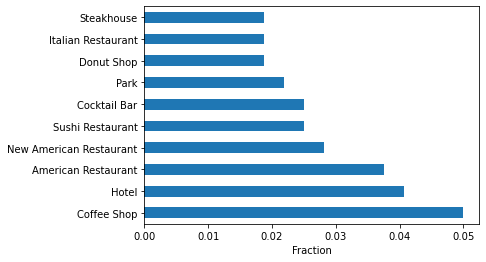

In [35]:
final_df["Venue Category"].value_counts(normalize=True).head(10).plot(kind="barh")
plt.xlabel('Fraction')
plt.savefig(os.path.join(figure_dir, "venue_distribution.png"), bbox_inches='tight', dpi=300)
# plt.close()

We comfirm we have 40 data points for each city and feature.

In [54]:
final_df.groupby('City').count().head()

,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating
City,,,,,,,,
Austin,40,40,40,40,40,40,40,40
Boston,40,40,40,40,40,40,40,40
Chicago,40,40,40,40,40,40,40,40
Colorado,40,40,40,40,40,40,40,40
Los Angeles,40,40,40,40,40,40,40,40


We need to prepare the dataset for K-means. As we know, k-means does not take non-numerical features as input. For this we one-hot-encode the venue categories. 

In [52]:
# one hot encoding
venue_cat_onehot = pd.get_dummies(final_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venue_cat_onehot['City'] = final_df['City'] 
venue_cat_onehot['Rating'] = final_df['Venue Rating'] 

print(venue_cat_onehot.shape)
venue_cat_onehot.head()

(320, 130)


,Accessories Store,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Filipino Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Historic Site,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Library,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Supply Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Resort,Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,City,Rating
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,San Francisco,9.2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,San Francisco,9.2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,San Francisco,8.9
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,San Francisco,8.9
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,San Francisco,9.3


We take care of repeating datapoints for each city by taking the mean of venues in each city. Similarly, we can take the `max`, `min` or any other parameter since it will have an effect on the clustering algorithm

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
final_grouped = venue_cat_onehot.groupby('City').mean().reset_index()
final_grouped

,City,Accessories Store,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Filipino Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Historic Site,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Library,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Supply Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Resort,Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Rating
0,Austin,0.000,0.025,0.000,0.000,0.025,0.000,0.000,0.000,0.00,0.000,0.000,0.025,0.000,0.000,0.025,0.00,0.000,0.000,0.000,0.000,0.050,0.000,0.025,0.000,0.025,0.000,0.075,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.00,0.000,0.000,0.000,0.000,0.025,0.000,0.025,0.000,0.00,0.000,0.000,0.000,0.000,0.100,0.025,0.000,0.000,0.000,0.025,0.000,0.000,0.025,0.000,0.025,0.000,0.000,0.000,0.000,0.05,0.000,0.025,0.000,0.000,0.025,0.000,0.000,0.025,0.025,0.000,0.000,0.000,0.000,0.000,0.025,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.050,0.000,0.025,0.025,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.7175
1,Boston,0.000,0.025,0.000,0.000,0.000,0.000,0.025,0.000,0.00,0.025,0.000,0.000,0.025,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.025,0.025,0.000,0.075,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.00,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.025,0.05,0.000,0.000,0.025,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.025,0.00,0.025,0.025,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.025,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.050,0.000,0.050,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.050,0.000,0.025,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.025,0.000,8.6100
2,Chicago,0.000,0.125,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.025,0.025,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.025,0.025,0.000,0.025,0.050,0.000,0.00,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.025,0.000,0.025,0.000,0.025,0.000,0.000,0.000,0.025,0.000,0.00,0.000,0.025,0.000,0.000,0.000,0.025,0.000,0.075,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.025,0.050,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.025,0.000,0.000,0.025,0.00,0.

Let us gather the top venues in each city.

In [56]:
num_top_venues = 5

for hood in final_grouped['City']:
    print("---- " + hood + " ----")
    temp = final_grouped[final_grouped['City'] == hood].drop(columns=["Rating"]).T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Austin ----
          Venue  Frequency
0         Hotel       0.10
1  Cocktail Bar       0.08
2  Burger Joint       0.05
3    Steakhouse       0.05
4        Lounge       0.05


---- Boston ----
                     Venue  Frequency
0              Coffee Shop       0.08
1  New American Restaurant       0.08
2     Gym / Fitness Center       0.05
3                Gastropub       0.05
4           Sandwich Place       0.05


---- Chicago ----
                     Venue  Frequency
0      American Restaurant       0.12
1               Donut Shop       0.08
2  New American Restaurant       0.08
3           Cosmetics Shop       0.05
4            Grocery Store       0.05


---- Colorado ----
                          Venue  Frequency
0  Theme Park Ride / Attraction       0.08
1                          Park       0.08
2                   Coffee Shop       0.08
3                   Yoga Studio       0.05
4                Ice Cream Shop       0.05


---- Los Angeles ----
            Venue  Freq

Borrowing the function from the previous labs we can also get the most common venues and append them to a dataframe. 

In [57]:
def return_most_common_venues(row, num_top_venues):
    '''Returns most common venues'''
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [58]:
# Sepcifying the number of venues to return
num_top_venues = 10

indicators = ['st', 'nd', 'rd', 'th', 'th', 'th', 'th', 'th', 'th', 'th', 'th']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with the same neighborhoods as in toronto_grouped
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = final_grouped['City']

# Fill each row on each column.
for ind in np.arange(final_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(final_grouped.drop(columns=["Rating"]).iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Austin,Hotel,Cocktail Bar,Lounge,Steakhouse,Coffee Shop,Burger Joint,Park,Cajun / Creole Restaurant,Chinese Restaurant,Salad Place
1,Boston,Coffee Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Sandwich Place,Salad Place,Gastropub,Hotel,Falafel Restaurant,Restaurant
2,Chicago,American Restaurant,New American Restaurant,Donut Shop,Grocery Store,Restaurant,Cosmetics Shop,Yoga Studio,Café,Salon / Barbershop,Resort
3,Colorado,Theme Park Ride / Attraction,Coffee Shop,Park,Yoga Studio,Ice Cream Shop,Café,Sushi Restaurant,Brewery,Pizza Place,Seafood Restaurant
4,Los Angeles,Plaza,Ice Cream Shop,Speakeasy,Coffee Shop,Theater,Jazz Club,Park,School,Candy Store,Historic Site
5,New York,Pizza Place,Sushi Restaurant,Bakery,Italian Restaurant,Food & Drink Shop,Bagel Shop,Deli / Bodega,Farmers Market,Mexican Restaurant,Bubble Tea Shop
6,San Francisco,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
7,Seattle,Hotel,Coffee Shop,Cocktail Bar,Concert Hall,Café,Donut Shop,Deli / Bodega,Seafood Restaurant,Scenic Lookout,Sandwich Place


In [68]:
import importlib
importlib.reload(geopy_utils)
importlib.reload(foursquare_utils)

<module 'foursquare_utils' from '/Users/pedrovicentevaldez/Desktop/TechHub_Cities_Comparison/foursquare_utils.py'>

We need to drop the `City` feature before processing the dataframe.

In [59]:
final_grouped_clustering = final_grouped.drop('City', 1)
final_grouped_clustering.head()

,Accessories Store,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Filipino Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Historic Site,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Library,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Supply Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Resort,Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Rating
0,0.0,0.025,0.000,0.000,0.025,0.000,0.000,0.0,0.0,0.000,0.0,0.025,0.000,0.0,0.025,0.00,0.0,0.000,0.0,0.000,0.050,0.000,0.025,0.000,0.025,0.000,0.075,0.050,0.000,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.025,0.000,0.0,0.0,0.000,0.000,0.000,0.025,0.000,0.025,0.000,0.00,0.000,0.0,0.000,0.000,0.100,0.025,0.00,0.000,0.000,0.025,0.000,0.000,0.025,0.000,0.025,0.0,0.000,0.000,0.000,0.05,0.000,0.025,0.0,0.0,0.025,0.000,0.000,0.025,0.025,0.0,0.0,0.000,0.0,0.0,0.025,0.025,0.0,0.000,0.000,0.000,0.000,0.000,0.025,0.0,0.025,0.000,0.00,0.0,0.000,0.000,0.025,0.0,0.000,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.050,0.000,0.025,0.025,0.000,0.0,0.000,0.025,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,8.7175
1,0.0,0.025,0.000,0.000,0.000,0.000,0.025,0.0,0.0,0.025,0.0,0.000,0.025,0.0,0.000,0.00,0.0,0.000,0.0,0.000,0.025,0.000,0.000,0.000,0.025,0.025,0.000,0.075,0.000,0.0,0.00,0.025,0.0,0.0,0.0,0.0,0.000,0.0,0.025,0.000,0.000,0.0,0.0,0.000,0.000,0.050,0.000,0.000,0.000,0.025,0.05,0.000,0.0,0.025,0.000,0.025,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.025,0.000,0.025,0.00,0.025,0.025,0.0,0.0,0.000,0.000,0.000,0.075,0.000,0.0,0.0,0.025,0.0,0.0,0.025,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.025,0.0,0.050,0.000,0.05,0.0,0.000,0.025,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.050,0.000,0.025,0.000,0.000,0.0,0.025,0.000,0.000,0.000,0.000,0.000,0.025,0.0,0.000,0.025,0.000,8.6100
2,0.0,0.125,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.00,0.0,0.000,0.0,0.000,0.025,0.025,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.0,0.05,0.000,0.0,0.0,0.0,0.0,0.075,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.025,0.025,0.000,0.025,0.050,0.000,0.00,0.000,0.0,0.000,0.000,0.025,0.000,0.00,0.000,0.000,0.025,0.000,0.025,0.000,0.025,0.000,0.0,0.000,0.025,0.000,0.00,0.000,0.025,0.0,0.0,0.000,0.025,0.000,0.075,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.025,0.000,0.000,0.000,0.025,0.050,0.0,0.000,0.025,0.00,0.0,0.000,0.000,0.025,0.0,0.000,0.025,0.0,0.0,0.025,0.00,0.025,0.000,0.025,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.0,0.000,0.000,0.025,8.8025
3,0.0,0.025,0.025,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.05,0.0,0.025,

# Normalizing Features

K-Means algorithms are deeply influenced by the magnitude of the features. In this case, the `Rating` feature is manigutdes higher than any other feature in the dataframe. Because of this, we will normalize the dataframe using the `StandardScaler` and the `MinMaxScaler` modules in `Scikit-Learn`. 

In [79]:
from sklearn import preprocessing

In [61]:
x = final_grouped_clustering #returns a numpy array

# Instantiating the scalers
min_max_scaler = preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()

# Fit and transform the dataframe
x_scaled_minmax = min_max_scaler.fit_transform(x)
x_scaled_std = std_scaler.fit_transform(x)

# Convert fitted values into a DataFrame
final_grouped_clustering_std_norm = pd.DataFrame(x_scaled_std, columns=final_grouped_clustering.columns)
final_grouped_clustering_mms_norm = pd.DataFrame(x_scaled_minmax, columns=final_grouped_clustering.columns)

In [62]:
final_grouped_clustering_std_norm.head()

,Accessories Store,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Filipino Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Historic Site,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Library,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Supply Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Resort,Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Rating
0,-0.377964,-0.377964,-0.377964,-0.577350,1.290994,-0.377964,-0.377964,-0.377964,-0.377964,-0.629941,-0.377964,1.732051,-0.577350,-0.377964,1.290994,-0.377964,-0.377964,-0.377964,-0.538816,-0.577350,2.121320,-0.729325,2.645751,-0.377964,1.290994,-0.707107,1.632993,0.000000,-0.538816,-0.377964,-0.538816,-0.707107,-0.377964,-0.377964,-0.377964,-0.377964,-0.688247,-0.377964,-0.377964,1.732051,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.538816,1.732051,-0.577350,0.538816,-0.774597,-0.577350,-0.377964,-0.377964,-0.577350,-0.577350,1.436265,2.645751,-0.729325,-0.377964,-0.377964,0.258199,-0.377964,-1.290994,1.732051,-0.577350,2.645751,-0.377964,-0.377964,-0.377964,-0.577350,2.645751,-0.577350,1.290994,-0.377964,-0.377964,2.645751,-0.774597,-0.577350,-0.107211,2.645751,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,0.13484,1.732051,-0.377964,-0.629941,-0.562544,-0.377964,-0.377964,-0.377964,0.707107,-0.377964,0.898027,-0.774597,-0.707107,-0.377964,-0.377964,-0.377964,1.0,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.577350,-0.377964,-0.577350,-0.377964,1.507557,-0.577350,0.0,2.645751,-0.377964,-0.377964,-0.377964,0.538816,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.577350,-0.377964,-0.538816,0.503871
1,-0.377964,-0.377964,-0.377964,-0.577350,-0.774597,-0.377964,2.645751,-0.377964,-0.377964,0.377964,-0.377964,-0.577350,1.732051,-0.377964,-0.774597,-0.377964,-0.377964,-0.377964,-0.538816,-0.577350,0.707107,-0.729325,-0.377964,-0.377964,1.290994,0.707107,-0.816497,0.816497,-0.538816,-0.377964,-0.538816,0.707107,-0.377964,-0.377964,-0.377964,-0.377964,-0.688247,-0.377964,2.645751,-0.577350,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,2.334869,-0.577350,-0.577350,-0.898027,1.290994,1.732051,-0.377964,-0.377964,1.732051,-0.577350,-0.377964,-0.377964,-0.729325,-0.377964,-0.377964,-0.774597,-0.377964,-1.290994,-0.577350,-0.577350,-0.377964,-0.377964,2.645751,-0.377964,1.732051,-0.377964,1.732051,1.290994,-0.377964,-0.377964,-0.377964,-0.774597,-0.577350,1.608169,-0.377964,-0.377964,-0.377964,2.645751,-0.377964,-0.377964,0.13484,-0.577350,-0.377964,-0.629941,-0.562544,-0.377964,-0.377964,-0.377964,0.707107,-0.377964,2.334869,-0.774597,2.121320,-0.377964,-0

In [84]:
cities_list = ["San Francisco, California", "Denver, Colorado", "Seattle, Washington"]
               
def get_analysis_per_city(city_state_list, num_venues=20, radius=1000):
#     cities_coordinates = geopy_utils.get_coordinates_df(city_state_list)
#     cities_coordinates["Cities"] = cities_coordinates["Cities"].apply(lambda x: x.split(",")[0])
    
#     final_df = foursquare_utils.getNearbyVenues(names = cities_coordinates['Cities'],
#                                latitudes = cities_coordinates['Latitude'],
#                                longitudes = cities_coordinates['Longitude'],
#                                LIMIT = num_venues,
#                                radius = radius)
    
#     final_df['Venue Rating'] = final_df.apply(foursquare_utils.get_rating, axis=1)
#     final_df.to_csv("cities_venues.csv", index=False)
    
    final_df = pd.read_csv("../datasets/cities_venues.csv")
    
    print('There are {} uniques venue categories.'.format(len(final_df['Venue Category'].unique())))
    final_df["Venue Category"].value_counts(normalize=True).head(10).plot(kind="barh")
    plt.xlabel('Fraction')
    plt.savefig("venue_distribution.png", bbox_inches='tight', dpi=300)
    plt.close()
    
    # one hot encoding
    venue_cat_onehot = pd.get_dummies(final_df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    venue_cat_onehot['City'] = final_df['City'] 
    venue_cat_onehot['Rating'] = final_df['Venue Rating'] 

    final_grouped = venue_cat_onehot.groupby('City').mean().reset_index()
    final_grouped.Rating = MinMaxScaler().fit_transform(final_grouped[["Rating"]])
    
    foursquare_utils.get_cities_common_venues(final_grouped=final_grouped)
    
    final_grouped_clustering_norm = prepare_data_for_kmeans(final_grouped)
    
    return final_grouped, final_grouped_clustering_norm

testing, testing2 = get_analysis_per_city(cities_list)

testing.head()

There are 44 uniques venue categories.


,City,American Restaurant,Aquarium,Art Museum,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Electronics Store,Furniture / Home Store,Grocery Store,Gym / Fitness Center,Hawaiian Restaurant,Hotel,Japanese Restaurant,Jewelry Store,Kitchen Supply Store,Liquor Store,Men's Store,Museum,Music Venue,Noodle House,Park,Pedestrian Plaza,Pizza Place,Plaza,Pub,Salon / Barbershop,Sandwich Place,Social Club,Spa,Sporting Goods Shop,Stadium,Steakhouse,Sushi Restaurant,Tapas Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Wine Bar,Rating
0,Denver,0.05,0.05,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.10,0.10,0.00,0.00,0.00,0.00,0.00,0.05,0.0,0.00,0.0,0.00,0.00,0.00,0.05,0.00,0.00,0.05,0.00,0.05,0.00,0.05,0.00,0.00,0.00,0.00,0.05,0.05,0.00,0.05,0.05,0.00,0.05,0.1,0.05,0.000000
1,San Francisco,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.05,0.05,0.05,0.00,0.00,0.05,0.05,0.05,0.05,0.00,0.0,0.00,0.1,0.05,0.05,0.05,0.00,0.05,0.00,0.00,0.05,0.00,0.05,0.00,0.05,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.000000
2,Seattle,0.05,0.00,0.05,0.00,0.05,0.00,0.05,0.00,0.05,0.10,0.15,0.05,0.00,0.00,0.00,0.00,0.00,0.1,0.05,0.0,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.05,0.05,0.00,0.00,0.05,0.00,0.00,0.05,0.00,0.0,0.00,0.391304


In [63]:
final_grouped_clustering_mms_norm.head()

,Accessories Store,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Filipino Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health & Beauty Service,Historic Site,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Library,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Supply Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Ramen Restaurant,Resort,Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Smoke Shop,Snack Place,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Rating
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.000000,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0,0.0,0.0,0.0,0.333333,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.928870
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.000000,0.75,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.838912
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.000000,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.333333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,1.000000
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.00,0.0,1.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.

In [85]:
testing2.head()

,American Restaurant,Aquarium,Art Museum,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Electronics Store,Furniture / Home Store,Grocery Store,Gym / Fitness Center,Hawaiian Restaurant,Hotel,Japanese Restaurant,Jewelry Store,Kitchen Supply Store,Liquor Store,Men's Store,Museum,Music Venue,Noodle House,Park,Pedestrian Plaza,Pizza Place,Plaza,Pub,Salon / Barbershop,Sandwich Place,Social Club,Spa,Sporting Goods Shop,Stadium,Steakhouse,Sushi Restaurant,Tapas Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Wine Bar,Rating
0,0.707107,1.414214,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-1.414214,0.707107,0.267261,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,1.414214,-0.707107,1.414214,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-1.414214,1.414214,1.414214,-0.707107,1.414214,1.414214,-0.707107,1.414214,1.414214,1.414214,-1.127152
1,-1.414214,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,1.414214,0.707107,-1.414214,-1.336306,-0.707107,1.414214,1.414214,1.414214,1.414214,-0.707107,-0.707107,-0.707107,1.414214,1.414214,1.414214,1.414214,-0.707107,1.414214,-0.707107,-0.707107,1.414214,-0.707107,1.414214,-0.707107,1.414214,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.303269
2,0.707107,-0.707107,1.414214,-0.707107,1.414214,-0.707107,1.414214,-0.707107,0.707107,0.707107,1.069045,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,1.414214,0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-0.176117


In [80]:
def prepare_data_for_kmeans(final_grouped, norm="std"):
    final_grouped_clustering = final_grouped.drop('City', 1)
    
    x = final_grouped_clustering #returns a numpy array

    if norm == "minmax":
        # Instantiating the scalers
        scaler = preprocessing.MinMaxScaler()
    elif norm == "std":
        scaler = preprocessing.StandardScaler()
    else:
        scaler = preprocessing.MinMaxScaler()

    # Fit and transform the dataframe
    x_scaled = scaler.fit_transform(x)

    # Convert fitted values into a DataFrame
    final_grouped_clustering_norm = pd.DataFrame(x_scaled, columns=final_grouped_clustering.columns)
    
    return final_grouped_clustering_norm

In [83]:
final_grouped_clustering_std_norm

,American Restaurant,Aquarium,Art Museum,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Electronics Store,Furniture / Home Store,Grocery Store,Gym / Fitness Center,Hawaiian Restaurant,Hotel,Japanese Restaurant,Jewelry Store,Kitchen Supply Store,Liquor Store,Men's Store,Museum,Music Venue,Noodle House,Park,Pedestrian Plaza,Pizza Place,Plaza,Pub,Salon / Barbershop,Sandwich Place,Social Club,Spa,Sporting Goods Shop,Stadium,Steakhouse,Sushi Restaurant,Tapas Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Wine Bar,Rating
0,0.707107,1.414214,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-1.414214,0.707107,0.267261,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,1.414214,-0.707107,1.414214,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-1.414214,1.414214,1.414214,-0.707107,1.414214,1.414214,-0.707107,1.414214,1.414214,1.414214,-1.127152
1,-1.414214,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,1.414214,0.707107,-1.414214,-1.336306,-0.707107,1.414214,1.414214,1.414214,1.414214,-0.707107,-0.707107,-0.707107,1.414214,1.414214,1.414214,1.414214,-0.707107,1.414214,-0.707107,-0.707107,1.414214,-0.707107,1.414214,-0.707107,1.414214,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.303269
2,0.707107,-0.707107,1.414214,-0.707107,1.414214,-0.707107,1.414214,-0.707107,0.707107,0.707107,1.069045,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,1.414214,1.414214,0.707107,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,1.414214,-0.707107,-0.707107,-0.707107,-0.176117


# Fitting Clustering Algorithm

We use the KMeans algorithm in the `Scikit-learn` package with 4 clusters.

In [65]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans_std = KMeans(n_clusters=kclusters, n_init=20, max_iter=500, random_state=100).fit(final_grouped_clustering_std_norm)
kmeans_min = KMeans(n_clusters=kclusters, n_init=20, max_iter=500, random_state=100).fit(final_grouped_clustering_mms_norm)

# check cluster labels generated for each row in the dataframe
kmeans_std.labels_[0:10] 

array([0, 0, 0, 0, 1, 2, 0, 0])

In [88]:
cities_list = ["San Francisco, California", "Denver, Colorado", "Seattle, Washington"]
               
def get_analysis_per_city(city_state_list, num_venues=20, radius=1000, clusters=3):
#     cities_coordinates = geopy_utils.get_coordinates_df(city_state_list)
#     cities_coordinates["Cities"] = cities_coordinates["Cities"].apply(lambda x: x.split(",")[0])
    
#     final_df = foursquare_utils.getNearbyVenues(names = cities_coordinates['Cities'],
#                                latitudes = cities_coordinates['Latitude'],
#                                longitudes = cities_coordinates['Longitude'],
#                                LIMIT = num_venues,
#                                radius = radius)
    
#     final_df['Venue Rating'] = final_df.apply(foursquare_utils.get_rating, axis=1)
#     final_df.to_csv("cities_venues.csv", index=False)
    
    final_df = pd.read_csv("../datasets/cities_venues.csv")
    
    print('There are {} uniques venue categories.'.format(len(final_df['Venue Category'].unique())))
    final_df["Venue Category"].value_counts(normalize=True).head(10).plot(kind="barh")
    plt.xlabel('Fraction')
    plt.savefig("venue_distribution.png", bbox_inches='tight', dpi=300)
    plt.close()
    
    # one hot encoding
    venue_cat_onehot = pd.get_dummies(final_df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    venue_cat_onehot['City'] = final_df['City'] 
    venue_cat_onehot['Rating'] = final_df['Venue Rating'] 

    final_grouped = venue_cat_onehot.groupby('City').mean().reset_index()
    final_grouped.Rating = MinMaxScaler().fit_transform(final_grouped[["Rating"]])
    
    neighborhoods_venues_sorted = foursquare_utils.get_cities_common_venues(final_grouped=final_grouped)
    
    final_grouped_clustering_norm = prepare_data_for_kmeans(final_grouped)
    
    # run k-means clustering
    kmeans_model = KMeans(n_clusters=clusters, n_init=20, max_iter=500, random_state=100).fit(
        final_grouped_clustering_norm)
    
    
    # add clustering labels
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_model.labels_)

    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    final_merged = final_df.join(neighborhoods_venues_sorted.set_index('City'), on='City')
    final_merged.to_csv("../datasets/clustering_results.csv", index=False)
    

    return final_merged, kmeans_model

testing, model = get_analysis_per_city(cities_list)

testing.head()

There are 44 uniques venue categories.


,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
1,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
2,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
3,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.8,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.4,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop


In [66]:
# Creating a copy of the city venues to attach clustering 
# labels for both the minmax and the standard scalers.
neighborhoods_venues_sorted_mms = neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted_std = neighborhoods_venues_sorted.copy()

# add clustering labels
neighborhoods_venues_sorted_std.insert(0, 'Cluster Labels', kmeans_std.labels_)
neighborhoods_venues_sorted_mms.insert(0, 'Cluster Labels', kmeans_min.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
final_merged_std = final_df.join(neighborhoods_venues_sorted_std.set_index('City'), on='City')
final_merged_mms = final_df.join(neighborhoods_venues_sorted_mms.set_index('City'), on='City')

# final_merged_std.head() 

In [89]:
testing["Cluster Labels"].unique()

array([1, 0, 2], dtype=int32)

In [67]:
final_merged_mms.head()

,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
1,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
2,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.9,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
3,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.3,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck


Let us get the unique labels.

In [81]:
final_grouped_clustering_std_norm = prepare_data_for_kmeans(testing)

In [68]:
final_merged_std["Cluster Labels"].unique()

array([0, 1, 2], dtype=int64)

In [69]:
final_merged_mms["Cluster Labels"].unique()

array([2, 0, 1], dtype=int64)

# Visualizing Results

In [71]:
# create map
latitude = 41.850033
longitude = -87.6500523
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_merged_mms['Venue Latitude'], final_merged_mms['Venue Longitude'], final_merged_mms['City'], final_merged_mms['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [70]:
# # create map
# latitude = 41.850033
# longitude = -87.6500523
# map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# # set color scheme for the clusters
# x = np.arange(kclusters)
# ys = [i + x + (i*x)**2 for i in range(kclusters)]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
# markers_colors = []
# for lat, lon, poi, cluster in zip(final_merged_std['Venue Latitude'], final_merged_std['Venue Longitude'], final_merged_std['City'], final_merged_std['Cluster Labels']):
#     label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#     folium.CircleMarker(
#         [lat, lon],
#         radius=5,
#         popup=label,
#         color=rainbow[int(cluster)-1],
#         fill=True,
#         fill_color=rainbow[int(cluster)-1],
#         fill_opacity=0.7).add_to(map_clusters)
       
# map_clusters

In [99]:
map_clusters.save("map.html")

### This displays the Folium Map as a saved image since it will not be visible in GitHub Viewer

In [107]:
cities_list = ["San Francisco, California", "Denver, Colorado", "Seattle, Washington"]
               
def get_analysis_per_city(city_state_list, num_venues=20, radius=1000, clusters=3):
#     cities_coordinates = geopy_utils.get_coordinates_df(city_state_list)
#     cities_coordinates["Cities"] = cities_coordinates["Cities"].apply(lambda x: x.split(",")[0])
    
#     final_df = foursquare_utils.getNearbyVenues(names = cities_coordinates['Cities'],
#                                latitudes = cities_coordinates['Latitude'],
#                                longitudes = cities_coordinates['Longitude'],
#                                LIMIT = num_venues,
#                                radius = radius)
    
#     final_df['Venue Rating'] = final_df.apply(foursquare_utils.get_rating, axis=1)
#     final_df.to_csv("cities_venues.csv", index=False)
    
    final_df = pd.read_csv("../datasets/cities_venues.csv")
    
    print('There are {} uniques venue categories.'.format(len(final_df['Venue Category'].unique())))
    final_df["Venue Category"].value_counts(normalize=True).head(10).plot(kind="barh")
    plt.xlabel('Fraction')
    plt.savefig("venue_distribution.png", bbox_inches='tight', dpi=300)
    plt.close()
    
    # one hot encoding
    venue_cat_onehot = pd.get_dummies(final_df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    venue_cat_onehot['City'] = final_df['City'] 
    venue_cat_onehot['Rating'] = final_df['Venue Rating'] 

    final_grouped = venue_cat_onehot.groupby('City').mean().reset_index()
    final_grouped.Rating = MinMaxScaler().fit_transform(final_grouped[["Rating"]])
    
    neighborhoods_venues_sorted = foursquare_utils.get_cities_common_venues(final_grouped=final_grouped)
    
    final_grouped_clustering_norm = prepare_data_for_kmeans(final_grouped)
    
    # run k-means clustering
    kmeans_model = KMeans(n_clusters=clusters, n_init=20, max_iter=500, random_state=100).fit(
        final_grouped_clustering_norm)
    
    
    # add clustering labels
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_model.labels_)

    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    final_merged = final_df.join(neighborhoods_venues_sorted.set_index('City'), on='City')
    final_merged.to_csv("../datasets/clustering_results.csv", index=False)
    
    map_clusters = generate_folium_map(clusters, final_merged)
    
    return final_merged, kmeans_model

testing, model = get_analysis_per_city(cities_list)

testing.head()

There are 44 uniques venue categories.


,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
1,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
2,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
3,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.8,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.4,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop


In [104]:
def generate_folium_map(num_clusters, final_df):
    # create map
    latitude = 39.7392
    longitude = -104.9903
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

    # set color scheme for the clusters
    x = np.arange(num_clusters)
    ys = [i + x + (i*x)**2 for i in range(num_clusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(final_df['Venue Latitude'], final_df['Venue Longitude'], final_df['City'], final_df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)

    map_clusters.save("clustering_results_map.html")
    
    return map_clusters

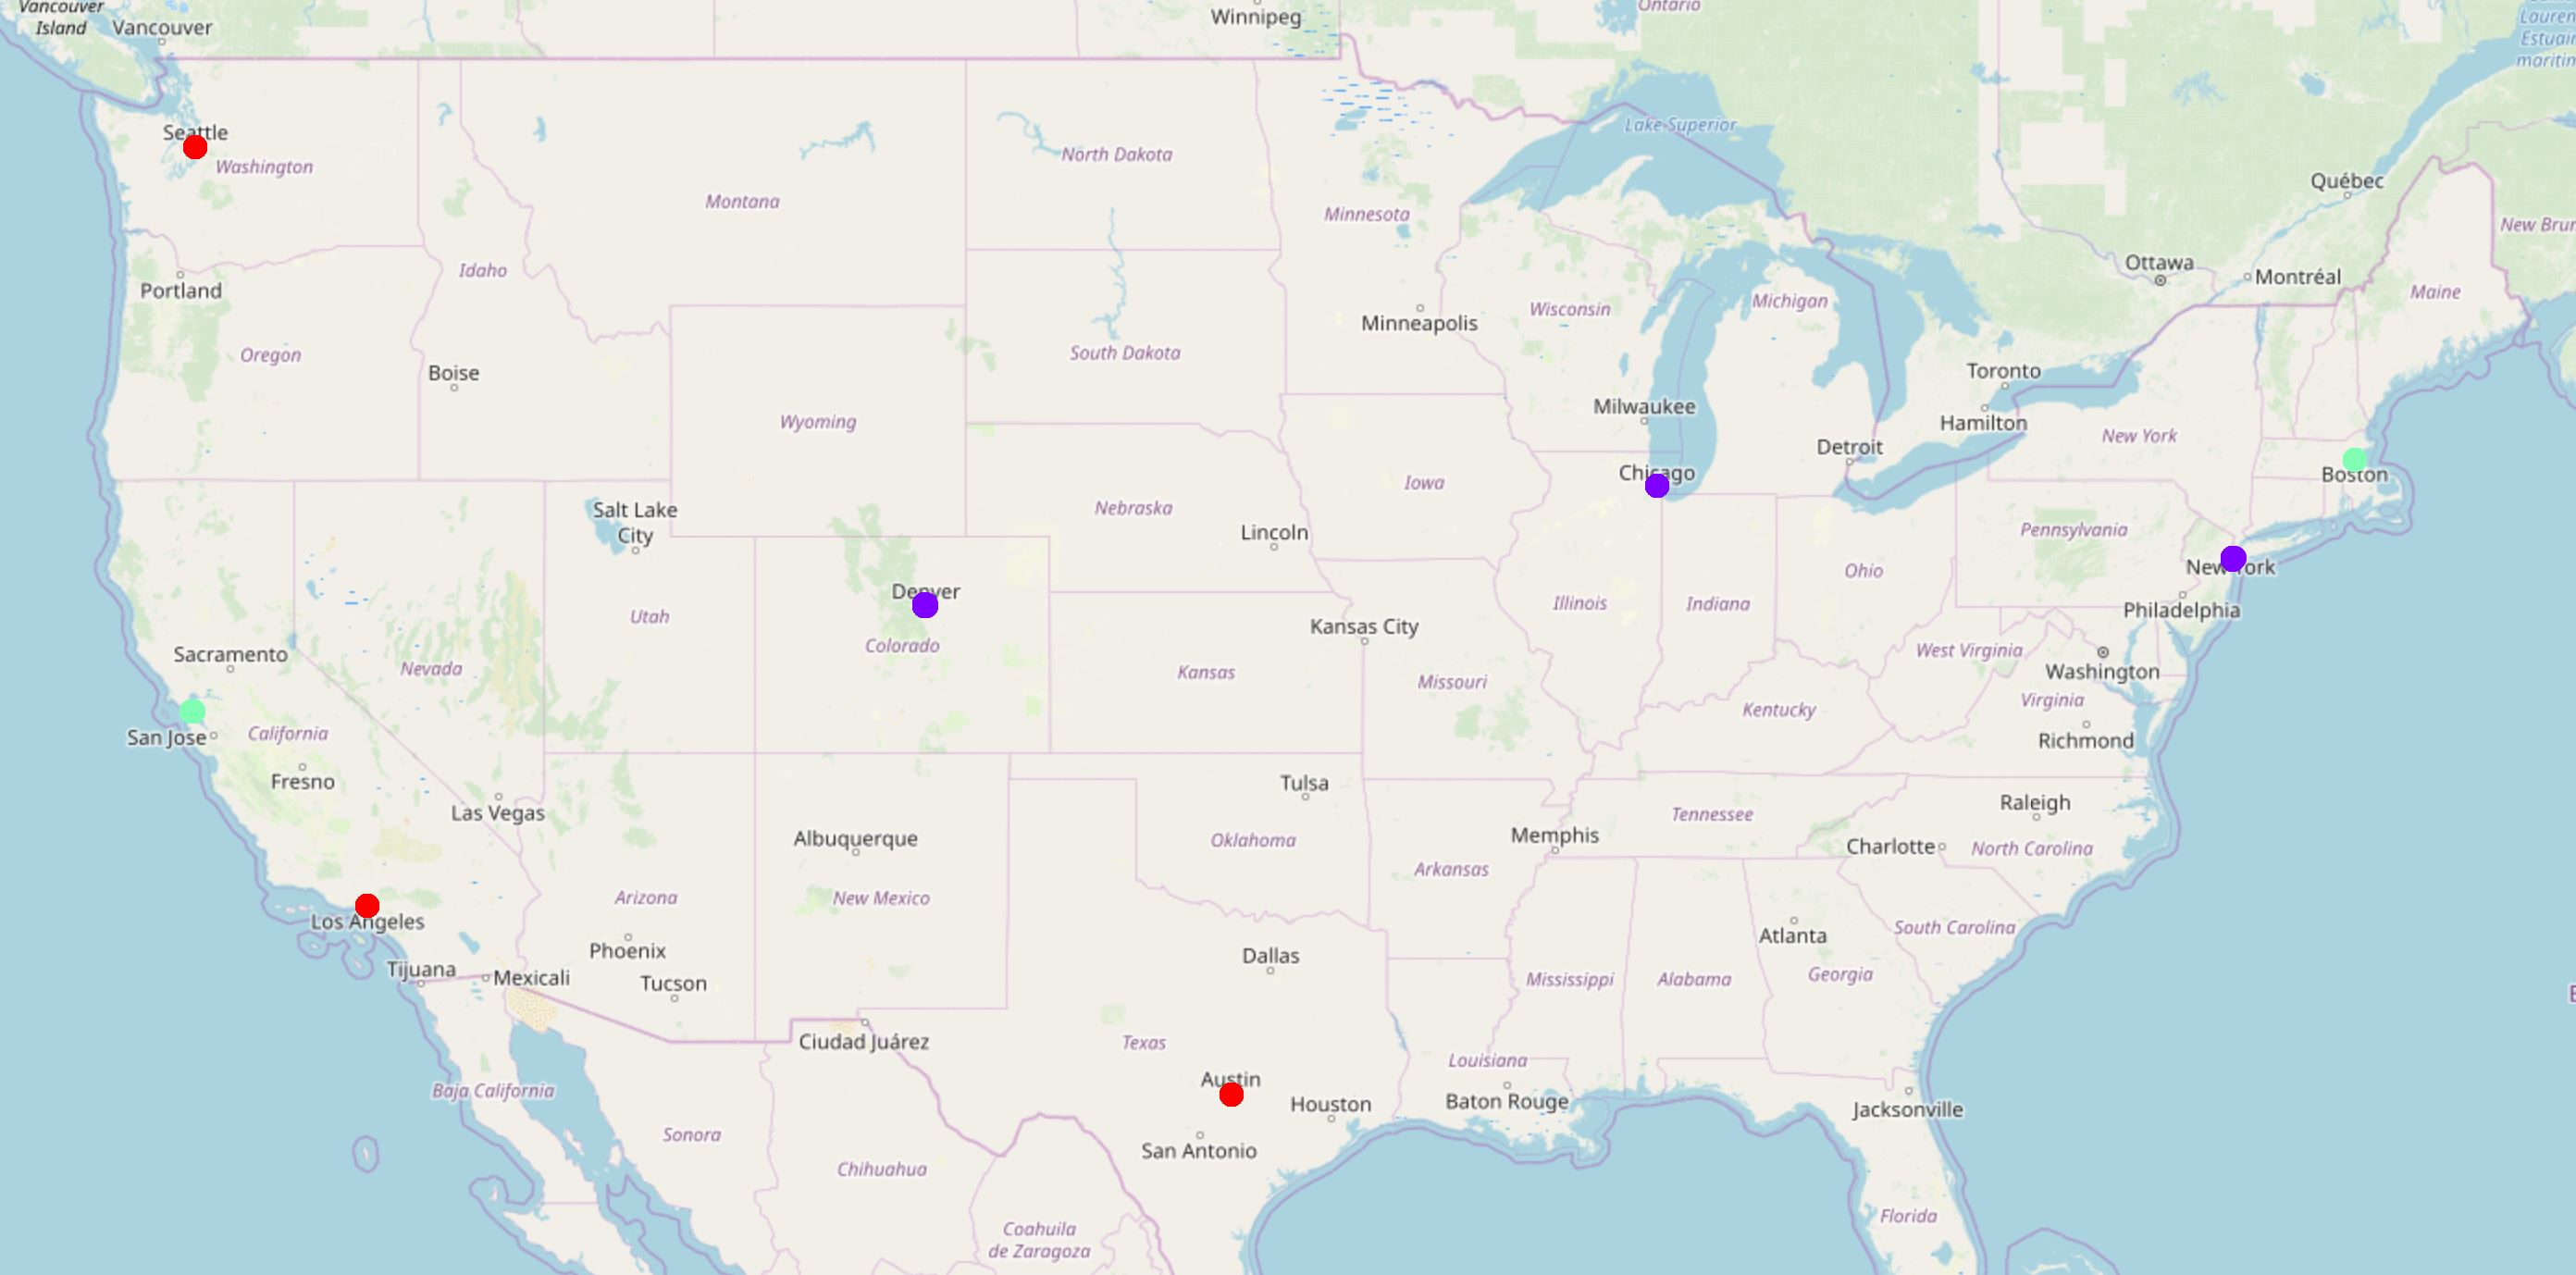

In [80]:
Image(filename='map1.JPG')

In [72]:
final_merged_mms.loc[final_merged_mms['Cluster Labels'] == 0, final_merged_mms.columns[[1] + list(range(5, final_merged_mms.shape[1]))]].head()

,City Latitude,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,34.053691,34.055034,-118.245179,Park,9.1,0,Plaza,Ice Cream Shop,Speakeasy,Coffee Shop,Theater,Jazz Club,Park,School,Candy Store,Historic Site
41,34.053691,34.051342,-118.244571,Indian Restaurant,8.6,0,Plaza,Ice Cream Shop,Speakeasy,Coffee Shop,Theater,Jazz Club,Park,School,Candy Store,Historic Site
42,34.053691,34.050666,-118.244068,American Restaurant,8.9,0,Plaza,Ice Cream Shop,Speakeasy,Coffee Shop,Theater,Jazz Club,Park,School,Candy Store,Historic Site
43,34.053691,34.050145,-118.242246,Bookstore,8.9,0,Plaza,Ice Cream Shop,Speakeasy,Coffee Shop,Theater,Jazz Club,Park,School,Candy Store,Historic Site
44,34.053691,34.054445,-118.244471,Arts & Crafts Store,8.0,0,Plaza,Ice Cream Shop,Speakeasy,Coffee Shop,Theater,Jazz Club,Park,School,Candy Store,Historic Site


In [100]:
testing

,City,City Latitude,City Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Francisco,37.787514,-122.407159,Saint Laurent,528d4fe211d2543b7663f4fd,37.787774,-122.405412,Boutique,9.2,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
1,San Francisco,37.787514,-122.407159,Maison Margiela,551cfcaf498e23f2c0115449,37.788261,-122.405765,Boutique,9.2,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
2,San Francisco,37.787514,-122.407159,Tiffany & Co.,4a791992f964a520efe61fe3,37.788598,-122.407708,Jewelry Store,8.9,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
3,San Francisco,37.787514,-122.407159,Williams-Sonoma,4aa45625f964a5207b4620e3,37.788377,-122.407446,Kitchen Supply Store,8.8,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
4,San Francisco,37.787514,-122.407159,The Archive,4b4bd8caf964a5207ba926e3,37.789494,-122.405766,Men's Store,9.4,1,Boutique,Jewelry Store,Liquor Store,Clothing Store,Furniture / Home Store,Plaza,Music Venue,Salon / Barbershop,Cocktail Bar,Bubble Tea Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,Seattle,47.604872,-122.333458,The Bar Shoppe,551366a2498e757161a41151,47.601737,-122.333130,Cocktail Bar,8.5,2,Coffee Shop,Hotel,Cocktail Bar,Social Club,Noodle House,Concert Hall,Clothing Store,Japanese Restaurant,Sandwich Place,American Restaurant
56,Seattle,47.604872,-122.333458,Cherry Street Coffee House,49d3e558f964a520225c1fe3,47.602767,-122.334151,Coffee Shop,8.1,2,Coffee Shop,Hotel,Cocktail Bar,Social Club,Noodle House,Concert Hall,Clothing Store,Japanese Restaurant,Sandwich Place,American Restaurant
57,Seattle,47.604872,-122.333458,The 5th Avenue Theatre,449ae181f964a5209f341fe3,47.608996,-122.334162,Theater,8.9,2,Coffee Shop,Hotel,Cocktail Bar,Social Club,Noodle House,Concert Hall,Clothing Store,Japanese Restaurant,Sandwich Place,American Restaurant
58,Seattle,47.604872,-122.333458,Starbucks Reserve Bar,58ad168cd8e55956ea9db67e,47.607027,-122.338199,Coffee Shop,8.7,2,Coffee Shop,Hotel,Cocktail Bar,Social Club,Noodle House,Concert Hall,Clothing Store,Japanese Restaurant,Sandwich Place,American Restaurant


In [73]:
final_merged_mms.loc[final_merged_mms['Cluster Labels'] == 1, final_merged_mms.columns[[1] + list(range(5, final_merged_mms.shape[1]))]].head()

,City Latitude,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
160,39.75177,39.749562,-105.013887,Theme Park Ride / Attraction,8.4,1,Theme Park Ride / Attraction,Coffee Shop,Park,Yoga Studio,Ice Cream Shop,Café,Sushi Restaurant,Brewery,Pizza Place,Seafood Restaurant
161,39.75177,39.748707,-105.017061,Museum,8.8,1,Theme Park Ride / Attraction,Coffee Shop,Park,Yoga Studio,Ice Cream Shop,Café,Sushi Restaurant,Brewery,Pizza Place,Seafood Restaurant
162,39.75177,39.755622,-105.009853,Sporting Goods Shop,9.3,1,Theme Park Ride / Attraction,Coffee Shop,Park,Yoga Studio,Ice Cream Shop,Café,Sushi Restaurant,Brewery,Pizza Place,Seafood Restaurant
163,39.75177,39.751776,-105.013673,Aquarium,7.6,1,Theme Park Ride / Attraction,Coffee Shop,Park,Yoga Studio,Ice Cream Shop,Café,Sushi Restaurant,Brewery,Pizza Place,Seafood Restaurant
164,39.75177,39.754487,-105.008569,Park,8.6,1,Theme Park Ride / Attraction,Coffee Shop,Park,Yoga Studio,Ice Cream Shop,Café,Sushi Restaurant,Brewery,Pizza Place,Seafood Restaurant


In [74]:
final_merged_mms.loc[final_merged_mms['Cluster Labels'] == 2, final_merged_mms.columns[[1] + list(range(5, final_merged_mms.shape[1]))]].head()

,City Latitude,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,37.787514,37.788261,-122.405765,Boutique,9.2,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
1,37.787514,37.787774,-122.405412,Boutique,9.2,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
2,37.787514,37.788377,-122.407446,Kitchen Supply Store,8.9,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
3,37.787514,37.788598,-122.407708,Jewelry Store,8.9,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck
4,37.787514,37.789494,-122.405766,Men's Store,9.3,2,Boutique,Hotel,Men's Store,Bubble Tea Shop,Clothing Store,Plaza,Gym / Fitness Center,Shoe Store,Music Venue,Food Truck


# Conclusions

Our hypothesis based on distance was wrong (expectedly). We observe that `Boston` is the most similar city to `San Francisco` based on the information gathered. This is pureley the result of the clustering algorithm. It is important to know the limitations of the current results. This result is base only on 40 recommended venues for each city (limited by the number of premium calls that allowed us to get the venue `Ratings`). This is not representative of an entire city but for the purposes of this project it will sufice. 

From the qualitative analysis we can see that both, Boston and San Francisco, have a high venue density of Boutiques, Stores and Hotels followed by Tea Places and Gyms. Parks are not even in the top 10 most common venues in contrast to the cluster #1 (Denver, Chicago, and New York) which has `Parks` as the 3rd most common venue.

# Verifying Results with 4 Clusters

In [75]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans_std = KMeans(n_clusters=kclusters, n_init=20, max_iter=500, random_state=100).fit(final_grouped_clustering_std_norm)
kmeans_min = KMeans(n_clusters=kclusters, n_init=20, max_iter=500, random_state=100).fit(final_grouped_clustering_mms_norm)

# check cluster labels generated for each row in the dataframe
kmeans_std.labels_[0:10] 

# Creating a copy of the city venues to attach clustering 
# labels for both the minmax and the standard scalers.
neighborhoods_venues_sorted_mms = neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted_std = neighborhoods_venues_sorted.copy()

# add clustering labels
neighborhoods_venues_sorted_std.insert(0, 'Cluster Labels', kmeans_std.labels_)
neighborhoods_venues_sorted_mms.insert(0, 'Cluster Labels', kmeans_min.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
final_merged_std = final_df.join(neighborhoods_venues_sorted_std.set_index('City'), on='City')
final_merged_mms = final_df.join(neighborhoods_venues_sorted_mms.set_index('City'), on='City')

# final_merged_std.head() 

# create map
latitude = 41.850033
longitude = -87.6500523
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_merged_mms['Venue Latitude'], final_merged_mms['Venue Longitude'], final_merged_mms['City'], final_merged_mms['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### This displays the Folium Map as a saved image since it will not be rendered by the GitHub Viewer

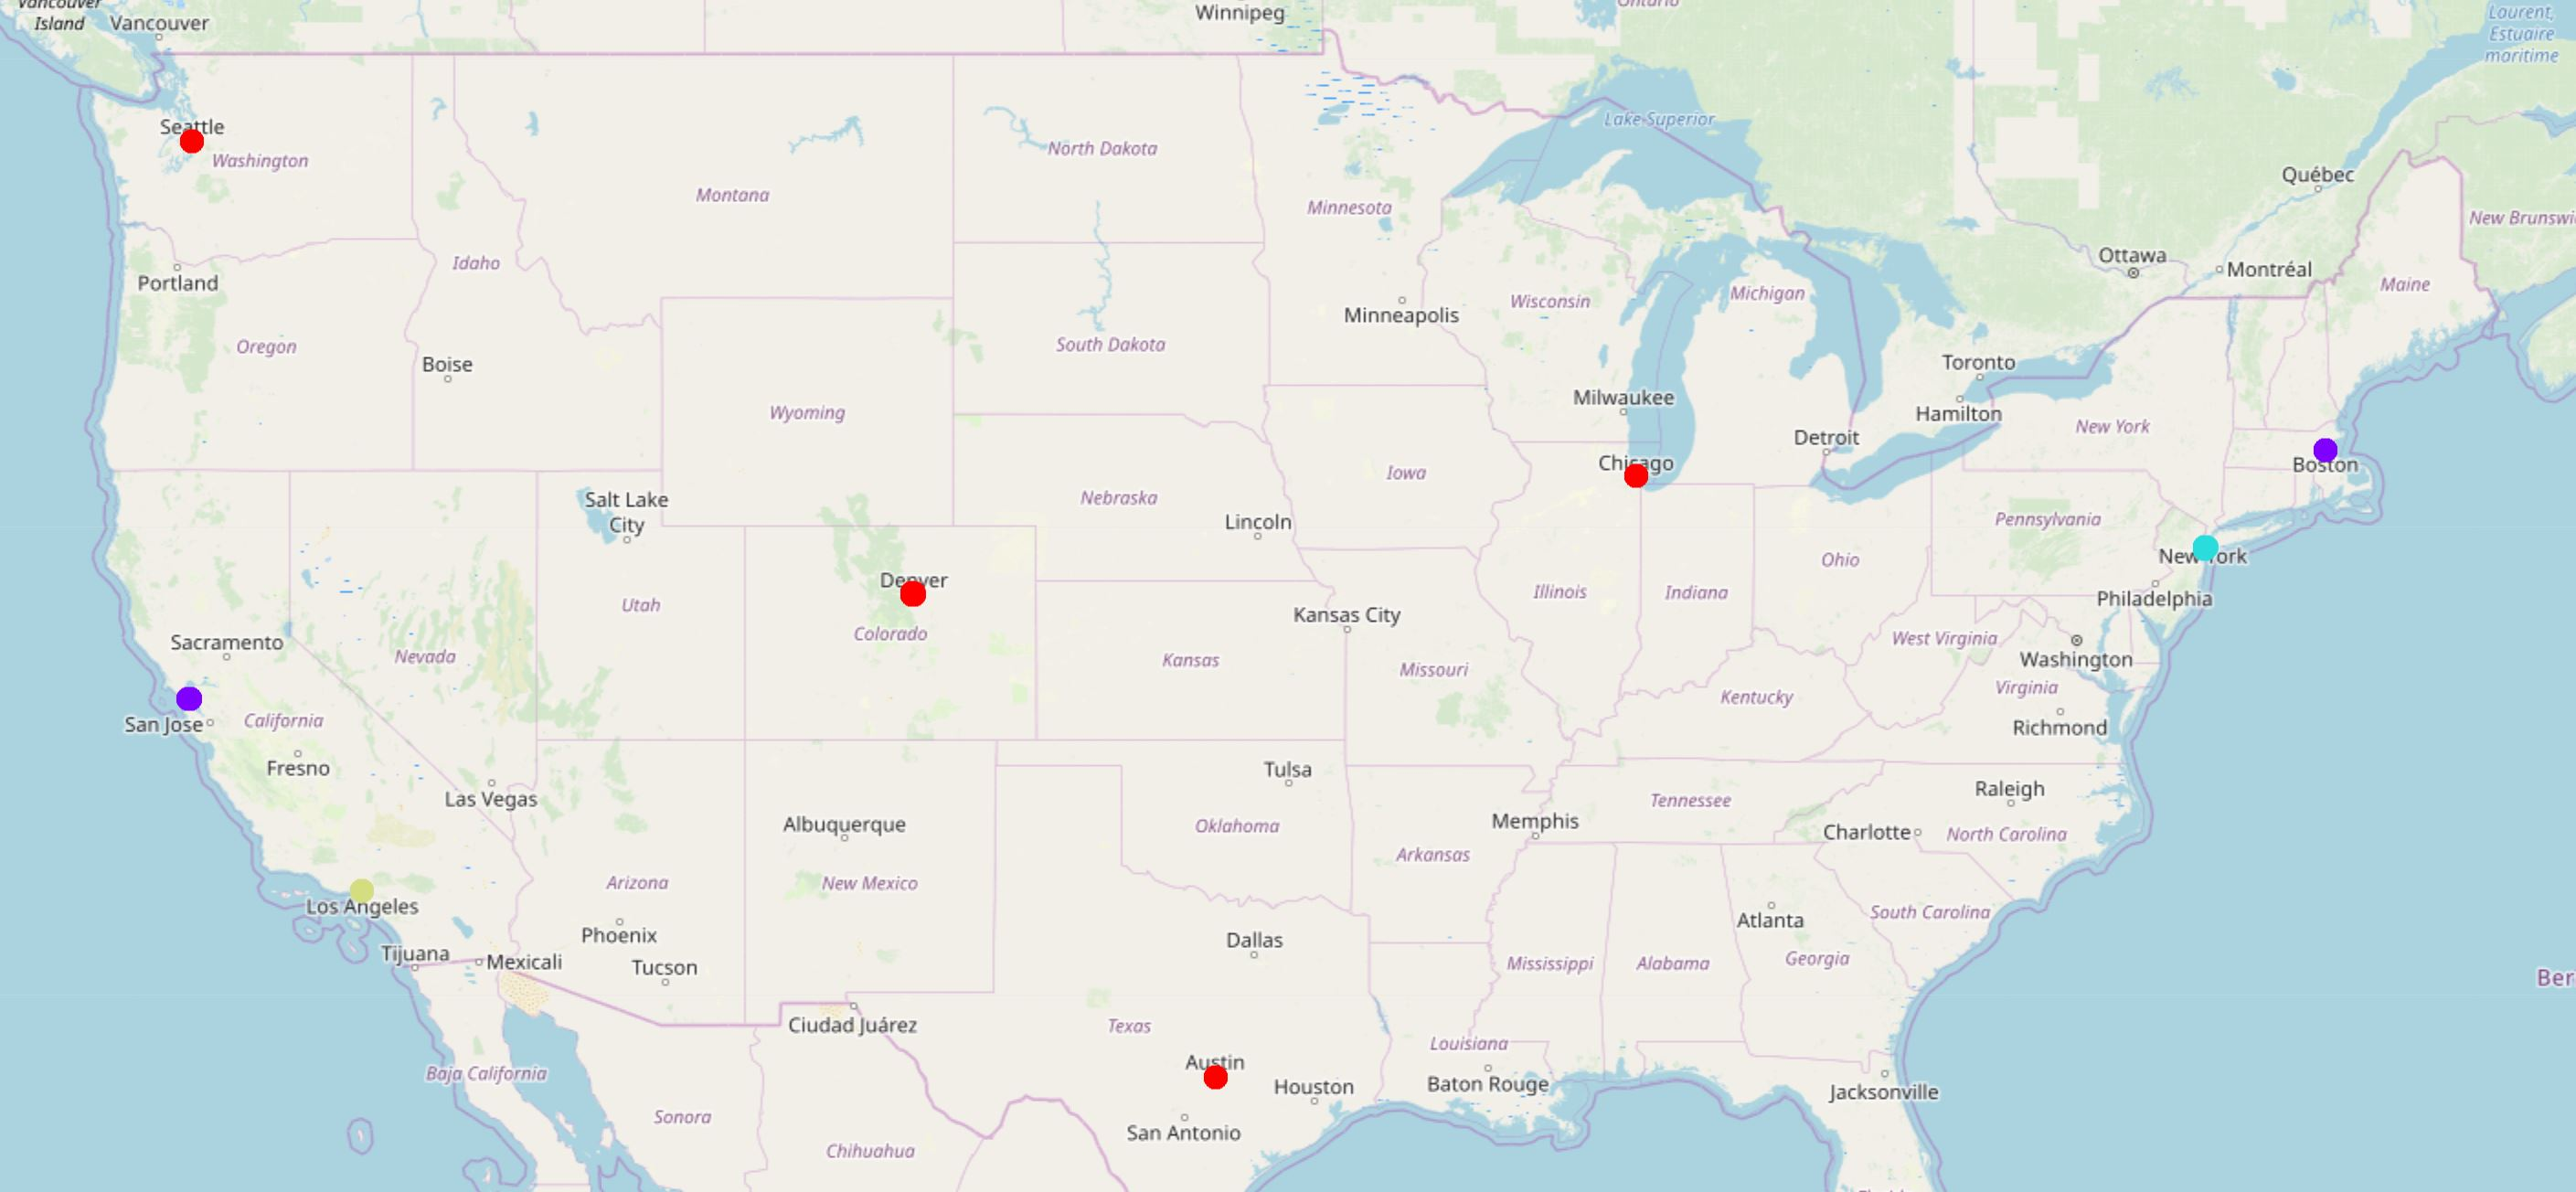

In [78]:
Image(filename='map2.JPG')